In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

2025-09-11 19:08:38.333405: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
csv_url = 'https://drive.google.com/uc?export=download&id=1hpsqSpfjdqIZWqwd259klQSeaNSe5Trr'
df = pd.read_csv(csv_url)
df.columns = ['timestamp', 'price', 'volume', 'rsi', 'macd', 'signal', 'histogram']
df['timestamp'] = pd.to_datetime(df['timestamp'],format='ISO8601')
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.head())
print(df.info())

            timestamp    price         volume        rsi       macd  \
0 2017-09-21 09:00:00  3860.00   74434.891166  49.192454 -48.279697   
1 2017-09-21 10:00:00  3871.48   44687.318944  49.233202 -47.780476   
2 2017-09-21 11:00:00  3864.95   80546.171672  49.210685 -47.308061   
3 2017-09-21 12:00:00  3858.08   90331.531390  49.186948 -46.863233   
4 2017-09-21 13:00:00  3856.67  103405.818040  49.182064 -46.425379   

      signal  histogram  
0  88.054720   2.495591  
1  87.996283   2.616710  
2  87.897128   2.532239  
3  87.720856   2.447245  
4  87.578086   2.424654  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53150 entries, 0 to 53149
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  53150 non-null  datetime64[ns]
 1   price      53150 non-null  float64       
 2   volume     53150 non-null  float64       
 3   rsi        53150 non-null  float64       
 4   macd       53150 non-n

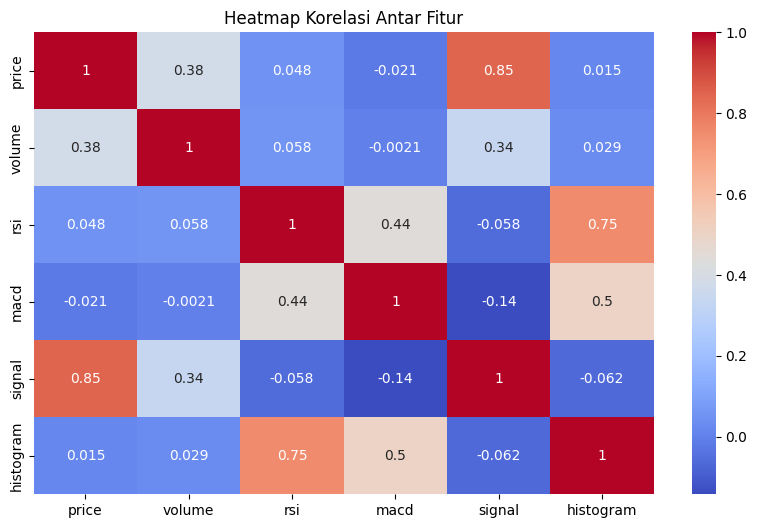

In [3]:
numeric_columns = ['price', 'volume', 'rsi', 'macd', 'signal', 'histogram']
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()

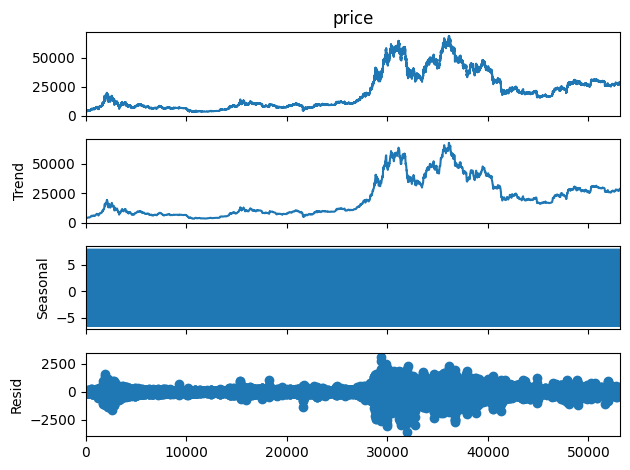

In [4]:
if len(df) > 24 * 2:
    try:
        decompose_result = seasonal_decompose(df['price'], model='additive', period=24)
        decompose_result.plot()
        plt.show()
    except Exception as e:
        print(f"Decomposition failed: {e}")
else:
    print("Data terlalu pendek untuk dekomposisi musiman.")

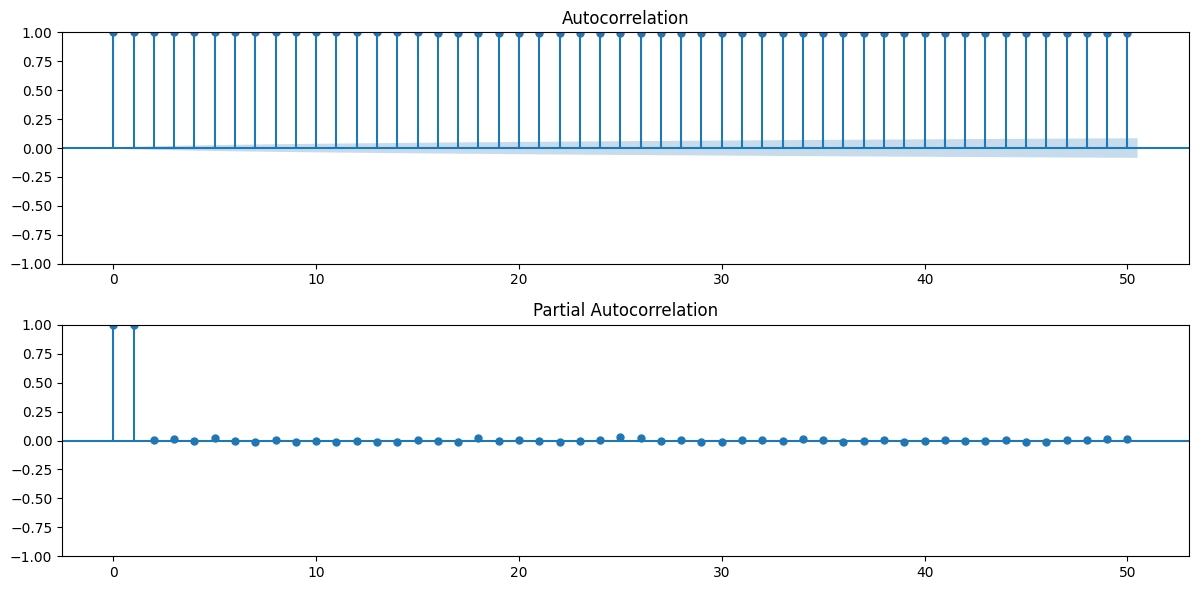

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df['price'], lags=50, ax=ax[0])
plot_pacf(df['price'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

In [6]:
df['rolling_mean_3'] = df['price'].rolling(window=3).mean()

print("NaN dalam df setelah feature engineering:")
print(df.isnull().sum())

df.dropna(inplace=True)
print("Data shape setelah dropna:", df.shape)

NaN dalam df setelah feature engineering:
timestamp         0
price             0
volume            0
rsi               0
macd              0
signal            0
histogram         0
rolling_mean_3    2
dtype: int64
Data shape setelah dropna: (53148, 8)


In [7]:
features = ['price', 'volume', 'rsi', 'rolling_mean_3']
target = 'price'

print("\nStatistik data sebelum scaling:")
print(df[features].describe())

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

print("\nNaN/Inf dalam scaled_")
print("NaN:", np.isnan(scaled_data).sum())
print("Inf:", np.isinf(scaled_data).sum())

def create_dataset(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        x_window = data[i:(i + window_size)]
        y_horizon = data[(i + window_size):(i + window_size + horizon), 0] 
        
        if np.isnan(x_window).any() or np.isinf(x_window).any() or \
           np.isnan(y_horizon).any() or np.isinf(y_horizon).any():
            continue
            
        X.append(x_window)
        y.append(y_horizon)
    return np.array(X), np.array(y)

WINDOW_SIZE = 24
HORIZON = 24

X, y = create_dataset(scaled_data, WINDOW_SIZE, HORIZON)

print("\nDataset shape setelah create_dataset:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Split data
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# tf.data.Dataset
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Statistik data sebelum scaling:
              price        volume           rsi  rolling_mean_3
count  53148.000000  5.314800e+04  53148.000000    53148.000000
mean   20595.986882  6.919475e+07     50.403649    20595.519795
std    15822.261859  1.059053e+08      3.210734    15821.816624
min     3172.050000  0.000000e+00     35.178834     3177.593333
25%     7977.695000  1.012631e+07     48.294163     7980.685833
50%    13881.760000  2.766440e+07     50.038592    13880.435000
75%    29647.800000  8.945139e+07     52.406430    29663.820000
max    68633.690000  3.005634e+09     64.657108    68502.336667

NaN/Inf dalam scaled_
NaN: 0
Inf: 0

Dataset shape setelah create_dataset:
X shape: (53101, 24, 4)
y shape: (53101, 24)


I0000 00:00:1757592554.412701   37560 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5660 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:07:00.0, compute capability: 8.6


In [8]:
# Custom Dense Layer
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(CustomDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.w) + self.b)

In [9]:
# Custom Multi-Head Attention Layer
class CustomMultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(CustomMultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

In [10]:
# Model Baseline LSTM
def build_baseline_lstm(input_shape, horizon):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        Dense(horizon)
    ])
    return model

model_baseline_lstm = build_baseline_lstm((WINDOW_SIZE, len(features)), HORIZON)
model_baseline_lstm.compile(optimizer='adam', loss='mse')
history_baseline = model_baseline_lstm.fit(train_dataset, epochs=20, validation_data=val_dataset, verbose=1)
model_baseline_lstm.save('model_baseline_lstm.keras')

Epoch 1/20


2025-09-11 19:09:17.524126: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0011 - val_loss: 0.0680
Epoch 2/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0027 - val_loss: 0.0709
Epoch 3/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0028 - val_loss: 0.0603
Epoch 4/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0022 - val_loss: 0.0556
Epoch 5/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0016 - val_loss: 0.0236
Epoch 6/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 7.0752e-04 - val_loss: 0.0082
Epoch 7/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 4.6313e-04 - val_loss: 0.0067
Epoch 8/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 3.9072e-04 - val_loss: 0.0057
Epoch 9/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 3.5037e-04 - val_loss: 0.0047
Epoch 10/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 3.1841e-04 - val_loss: 0.0040
Epoch 11/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 2.9366e-04 - val_loss: 0.

In [11]:
# Seq2Seq dengan Functional API + Attention
def build_seq2seq_functional(input_shape, horizon):
    inputs = Input(shape=input_shape)
    encoder_out = LSTM(64, return_sequences=True)(inputs)
    
    attention_layer = CustomMultiHeadAttention(d_model=64, num_heads=4)
    context_vector, _ = attention_layer(encoder_out, encoder_out, encoder_out)
    
    decoder_out = LSTM(64, return_sequences=False)(context_vector)
    outputs = Dense(horizon)(decoder_out)
    model = Model(inputs, outputs)
    return model

seq2seq_lstm_model = build_seq2seq_functional((WINDOW_SIZE, len(features)), HORIZON)
seq2seq_lstm_model.compile(optimizer='adam', loss='mse')
history_seq2seq = seq2seq_lstm_model.fit(train_dataset, epochs=20, validation_data=val_dataset, verbose=1)
seq2seq_lstm_model.save('seq2seq_lstm_model.keras')

Epoch 1/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 0.0014 - val_loss: 0.0858
Epoch 2/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0029 - val_loss: 0.0765
Epoch 3/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0033 - val_loss: 0.0751
Epoch 4/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0037 - val_loss: 0.0824
Epoch 5/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0177 - val_loss: 0.0895
Epoch 6/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0570 - val_loss: 0.0453
Epoch 7/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0567 - val_loss: 0.0380
Epoch 8/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0567 - val_loss: 0.0359
Epoch 9/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0567 - val_loss: 0.0352
Epoch 10/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0567 - val_loss: 0.0350
Epoch 11/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0567 - val_loss: 0.0349
Epoch 12

In [12]:
# Seq2Seq dengan Subclassing + Custom Layer + Attention
class CustomSeq2SeqModel(tf.keras.Model):
    def __init__(self, input_dim, d_model, num_heads, horizon):
        super(CustomSeq2SeqModel, self).__init__()
        self.encoder_lstm = LSTM(d_model, return_sequences=True)
        self.attention = CustomMultiHeadAttention(d_model, num_heads)
        self.decoder_lstm = LSTM(d_model, return_sequences=False)
        self.custom_dense = CustomDense(horizon)

    def call(self, inputs, training=None):
        encoder_out = self.encoder_lstm(inputs)
        context_vector, _ = self.attention(encoder_out, encoder_out, encoder_out)
        decoder_out = self.decoder_lstm(context_vector)
        output = self.custom_dense(decoder_out)
        return output

best_seq2seq_lstm_model = CustomSeq2SeqModel(
    input_dim=len(features),
    d_model=64,
    num_heads=4,
    horizon=HORIZON
)

best_seq2seq_lstm_model.compile(optimizer='adam', loss='mse')
history_best = best_seq2seq_lstm_model.fit(train_dataset, epochs=20, validation_data=val_dataset, verbose=1)
best_seq2seq_lstm_model.save('best_seq2seq_lstm_model.keras')

Epoch 1/20


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.0014 - val_loss: 0.0773
Epoch 2/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 0.0047 - val_loss: 0.1102
Epoch 3/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0068 - val_loss: 0.0950
Epoch 4/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0069 - val_loss: 0.1508
Epoch 5/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0064 - val_loss: 0.0965
Epoch 6/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 0.0044 - val_loss: 0.0902
Epoch 7/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 0.0092 - val_loss: 0.1827
Epoch 8/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0144 - val_loss: 0.1550
Epoch 9/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0104 - val_loss: 0.1464
Epoch 10/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0070 - val_loss: 0.1081
Epoch 11/20
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0049 - val_loss: 0.1116
Epoch 12/20
1162/11

In [13]:
# Custom MAE Loss
def custom_mae_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# Custom Weighted Loss
def weighted_mse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    weights = tf.linspace(1.0, 0.1, HORIZON)
    weights = tf.reshape(weights, (1, -1))
    squared_diff = tf.square(y_true - y_pred)
    weighted_squared_diff = squared_diff * weights
    return tf.reduce_mean(weighted_squared_diff)

# Custom Callbacks
class CustomEarlyStopping:
    def __init__(self, monitor='val_loss', patience=15, min_delta=1e-5, mode='min'):
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        if self.mode == 'min':
            self.best_loss = np.inf
        else:
            self.best_loss = -np.inf
        self.wait = 0
        self.stop_training = False

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor)
        if current_loss is None:
            return
            
        if self.mode == 'min':
            if current_loss < self.best_loss - self.min_delta:
                self.best_loss = current_loss
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"\nEpoch {epoch+1}: early stopping (monitor: {self.monitor})")
                    self.stop_training = True
        else:
            if current_loss > self.best_loss + self.min_delta:
                self.best_loss = current_loss
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"\nEpoch {epoch+1}: early stopping (monitor: {self.monitor})")
                    self.stop_training = True

class CustomReduceLROnPlateau:
    def __init__(self, optimizer, monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, mode='min'):
        self.optimizer = optimizer
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = tf.constant(min_lr, dtype=tf.float32)
        self.mode = mode
        if self.mode == 'min':
            self.best_loss = np.inf
        else:
            self.best_loss = -np.inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor)
        if current_loss is None:
            return
            
        if self.mode == 'min':
            if current_loss < self.best_loss:
                self.best_loss = current_loss
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    current_lr = self.optimizer.learning_rate
                    new_lr = current_lr * self.factor
                    if new_lr > self.min_lr:
                        self.optimizer.learning_rate.assign(new_lr)
                        print(f"\nEpoch {epoch+1}: reducing learning rate to {new_lr:.2e} (monitor: {self.monitor}).")
                    self.wait = 0
        else:
            if current_loss > self.best_loss:
                self.best_loss = current_loss
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    current_lr = self.optimizer.learning_rate
                    new_lr = current_lr * self.factor
                    if new_lr > self.min_lr:
                        self.optimizer.learning_rate.assign(new_lr)
                        print(f"\nEpoch {epoch+1}: reducing learning rate to {new_lr:.2e} (monitor: {self.monitor}).")
                    self.wait = 0

In [14]:
import tensorflow as tf
import numpy as np

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

loss_fn = weighted_mse_loss

train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = best_seq2seq_lstm_model(x, training=True)
        loss = loss_fn(y, predictions)

    gradients = tape.gradient(loss, best_seq2seq_lstm_model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, best_seq2seq_lstm_model.trainable_variables))

    train_loss_metric.update_state(loss)
    return loss

@tf.function
def val_step(x, y):
    predictions = best_seq2seq_lstm_model(x, training=False)
    loss = loss_fn(y, predictions)

    val_loss_metric.update_state(loss)
    return loss

best_val_loss = np.inf
best_weights = None

early_stop_callback = CustomEarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=1e-5,
    mode='min'
)

reduce_lr_callback = CustomReduceLROnPlateau(
    optimizer,
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    mode='min'
)

best_seq2seq_lstm_model.compile(optimizer=optimizer, loss=loss_fn)

EPOCHS = 200

for epoch in range(EPOCHS):
    train_loss_metric.reset_state()
    val_loss_metric.reset_state()

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        train_step(x_batch_train, y_batch_train)

    epoch_train_loss = train_loss_metric.result()

    for x_batch_val, y_batch_val in val_dataset:
        val_step(x_batch_val, y_batch_val)

    epoch_val_loss = val_loss_metric.result()

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_weights = best_seq2seq_lstm_model.get_weights()
        print(f"Epoch {epoch+1}: Val loss improved to {epoch_val_loss:.6f}, saving weights.")

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Loss: {epoch_train_loss:.6f} Val Loss: {epoch_val_loss:.6f}")
 
    logs = {'loss': epoch_train_loss.numpy(), 'val_loss': epoch_val_loss.numpy()}

    early_stop_callback.on_epoch_end(epoch, logs)
    reduce_lr_callback.on_epoch_end(epoch, logs)

    if early_stop_callback.stop_training:
        print(f"Training dihentikan oleh Early Stopping pada epoch {epoch+1}.")
        break

if best_weights is not None:
    print(f"\nMemulihkan bobot terbaik dengan val_loss: {best_val_loss:.6f}")
    best_seq2seq_lstm_model.set_weights(best_weights)
else:
    print("\nTidak ada bobot terbaik yang disimpan.")

best_seq2seq_lstm_model.save('best_seq2seq_lstm_model.keras')
print("Model disimpan ke 'best_seq2seq_lstm_model.keras'.")

2025-09-11 19:28:31.490452: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-11 19:28:32.840746: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: Val loss improved to 0.053080, saving weights.
Epoch 1/200
Loss: 0.046594 Val Loss: 0.053080


2025-09-11 19:28:48.437727: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2: Val loss improved to 0.043992, saving weights.
Epoch 2/200
Loss: 0.006242 Val Loss: 0.043992
Epoch 3: Val loss improved to 0.024816, saving weights.
Epoch 3/200
Loss: 0.002521 Val Loss: 0.024816


2025-09-11 19:29:20.200279: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4: Val loss improved to 0.008487, saving weights.
Epoch 4/200
Loss: 0.000929 Val Loss: 0.008487
Epoch 5: Val loss improved to 0.003301, saving weights.
Epoch 5/200
Loss: 0.000483 Val Loss: 0.003301
Epoch 6/200
Loss: 0.000385 Val Loss: 0.003546
Epoch 7/200
Loss: 0.000375 Val Loss: 0.003794


2025-09-11 19:30:22.812069: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/200
Loss: 0.000359 Val Loss: 0.003521
Epoch 9: Val loss improved to 0.002970, saving weights.
Epoch 9/200
Loss: 0.000337 Val Loss: 0.002970
Epoch 10: Val loss improved to 0.002484, saving weights.
Epoch 10/200
Loss: 0.000325 Val Loss: 0.002484
Epoch 11: Val loss improved to 0.002269, saving weights.
Epoch 11/200
Loss: 0.000294 Val Loss: 0.002269
Epoch 12: Val loss improved to 0.002134, saving weights.
Epoch 12/200
Loss: 0.000283 Val Loss: 0.002134
Epoch 13: Val loss improved to 0.002083, saving weights.
Epoch 13/200
Loss: 0.000272 Val Loss: 0.002083
Epoch 14: Val loss improved to 0.002052, saving weights.
Epoch 14/200
Loss: 0.000264 Val Loss: 0.002052
Epoch 15: Val loss improved to 0.002037, saving weights.
Epoch 15/200
Loss: 0.000257 Val Loss: 0.002037


2025-09-11 19:32:29.039283: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/200
Loss: 0.000252 Val Loss: 0.002040
Epoch 17/200
Loss: 0.000248 Val Loss: 0.002053
Epoch 18/200
Loss: 0.000244 Val Loss: 0.002069
Epoch 19/200
Loss: 0.000241 Val Loss: 0.002088
Epoch 20/200
Loss: 0.000239 Val Loss: 0.002106

Epoch 20: reducing learning rate to 5.00e-05 (monitor: val_loss).
Epoch 21: Val loss improved to 0.001492, saving weights.
Epoch 21/200
Loss: 0.000259 Val Loss: 0.001492
Epoch 22: Val loss improved to 0.001030, saving weights.
Epoch 22/200
Loss: 0.000231 Val Loss: 0.001030
Epoch 23: Val loss improved to 0.000951, saving weights.
Epoch 23/200
Loss: 0.000223 Val Loss: 0.000951
Epoch 24: Val loss improved to 0.000932, saving weights.
Epoch 24/200
Loss: 0.000221 Val Loss: 0.000932
Epoch 25: Val loss improved to 0.000927, saving weights.
Epoch 25/200
Loss: 0.000219 Val Loss: 0.000927
Epoch 26: Val loss improved to 0.000924, saving weights.
Epoch 26/200
Loss: 0.000218 Val Loss: 0.000924
Epoch 27: Val loss improved to 0.000921, saving weights.
Epoch 27/200
Loss

2025-09-11 19:36:29.543903: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/200
Loss: 0.000211 Val Loss: 0.000934
Epoch 33/200
Loss: 0.000212 Val Loss: 0.000936
Epoch 34/200
Loss: 0.000212 Val Loss: 0.000932

Epoch 34: reducing learning rate to 2.50e-05 (monitor: val_loss).
Epoch 35: Val loss improved to 0.000575, saving weights.
Epoch 35/200
Loss: 0.000230 Val Loss: 0.000575
Epoch 36: Val loss improved to 0.000520, saving weights.
Epoch 36/200
Loss: 0.000215 Val Loss: 0.000520
Epoch 37: Val loss improved to 0.000461, saving weights.
Epoch 37/200
Loss: 0.000214 Val Loss: 0.000461
Epoch 38: Val loss improved to 0.000423, saving weights.
Epoch 38/200
Loss: 0.000214 Val Loss: 0.000423
Epoch 39: Val loss improved to 0.000400, saving weights.
Epoch 39/200
Loss: 0.000213 Val Loss: 0.000400
Epoch 40: Val loss improved to 0.000388, saving weights.
Epoch 40/200
Loss: 0.000212 Val Loss: 0.000388
Epoch 41: Val loss improved to 0.000383, saving weights.
Epoch 41/200
Loss: 0.000210 Val Loss: 0.000383
Epoch 42: Val loss improved to 0.000381, saving weights.
Epoch 4

2025-09-11 19:44:53.581482: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64/200
Loss: 0.000184 Val Loss: 0.000265
Epoch 65/200
Loss: 0.000183 Val Loss: 0.000266
Epoch 66/200
Loss: 0.000182 Val Loss: 0.000267
Epoch 67/200
Loss: 0.000182 Val Loss: 0.000267

Epoch 67: reducing learning rate to 3.12e-06 (monitor: val_loss).
Epoch 68: Val loss improved to 0.000259, saving weights.
Epoch 68/200
Loss: 0.000183 Val Loss: 0.000259
Epoch 69: Val loss improved to 0.000258, saving weights.
Epoch 69/200
Loss: 0.000182 Val Loss: 0.000258
Epoch 70/200
Loss: 0.000181 Val Loss: 0.000259
Epoch 71/200
Loss: 0.000181 Val Loss: 0.000260
Epoch 72/200
Loss: 0.000180 Val Loss: 0.000260
Epoch 73/200
Loss: 0.000180 Val Loss: 0.000261
Epoch 74/200
Loss: 0.000180 Val Loss: 0.000262

Epoch 74: reducing learning rate to 1.56e-06 (monitor: val_loss).
Epoch 75/200
Loss: 0.000180 Val Loss: 0.000260
Epoch 76/200
Loss: 0.000180 Val Loss: 0.000260

Epoch 76: early stopping (monitor: val_loss)
Training dihentikan oleh Early Stopping pada epoch 76.

Memulihkan bobot terbaik dengan val_los

In [15]:
test_predictions = best_seq2seq_lstm_model.predict(test_dataset)
test_mae = custom_mae_loss(y_test, test_predictions)
print(f"Test MAE: {test_mae.numpy()}") 

best_seq2seq_lstm_model.save('best_seq2seq_lstm_model.keras')
print("Model saved successfully.")

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test MAE: 0.014350349083542824
Model saved successfully.


249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


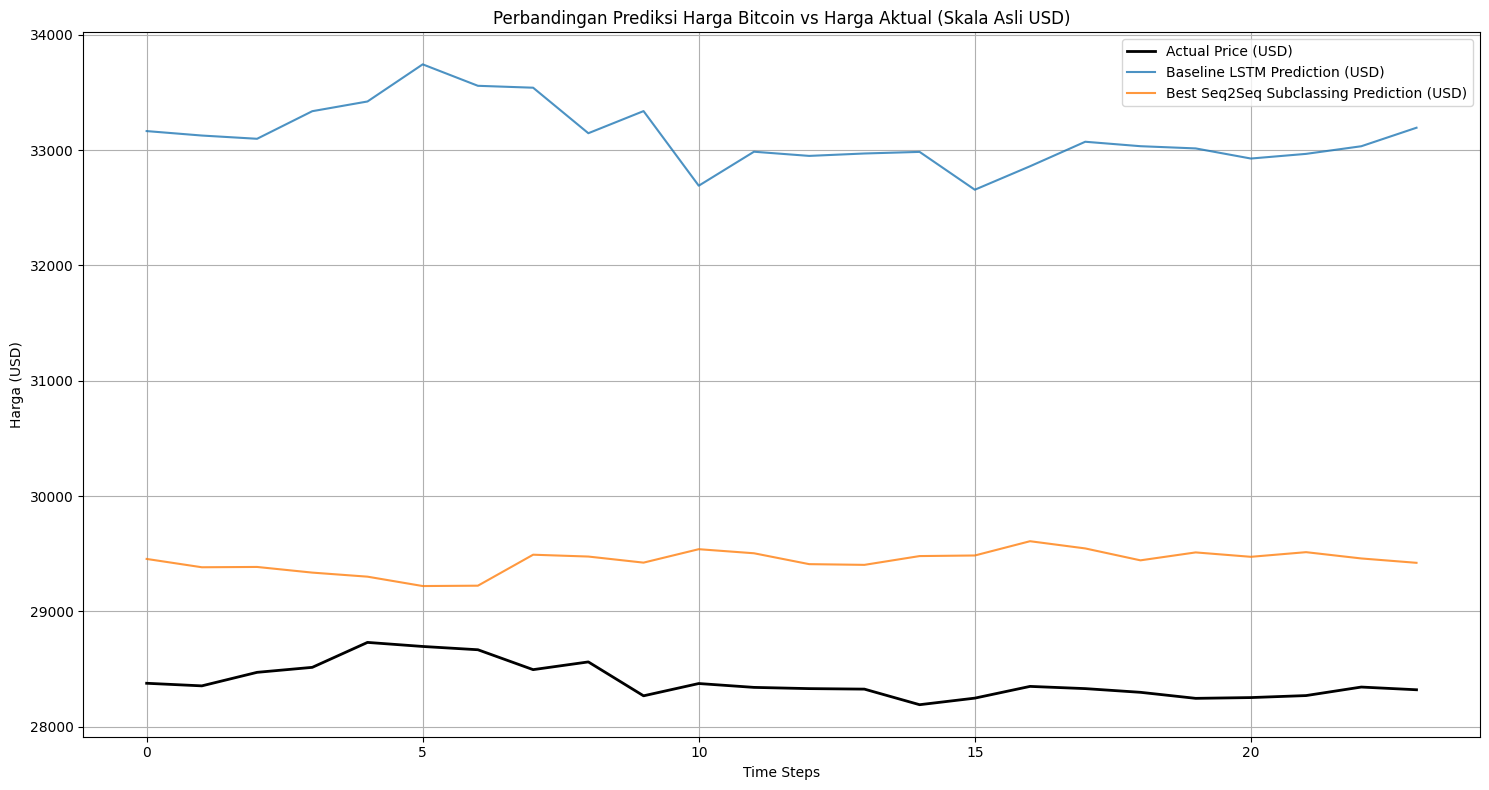


Tabel Perbandingan Prediksi Langkah Pertama (Skala Asli USD):
 Time Step  Actual Price (USD)  Baseline LSTM Pred (USD)  Seq2Seq Best Pred (USD)  Selisih (Actual - Best Seq2Seq) (USD)
         0            28376.34                  33164.48                 29454.46                               -1078.12
         1            28353.88                  33125.88                 29382.29                               -1028.41
         2            28471.15                  33097.75                 29385.00                                -913.85
         3            28514.42                  33337.00                 29335.94                                -821.52
         4            28730.72                  33421.22                 29300.73                                -570.01
         5            28695.50                  33743.17                 29219.43                                -523.93
         6            28667.03                  33557.17                 29222.50         

In [44]:
pred_baseline = model_baseline_lstm.predict(test_dataset)
pred_seq2seq_best = best_seq2seq_lstm_model.predict(test_dataset)

def inverse_transform_price(scaled_price_array):
    dummy_array = np.zeros((len(scaled_price_array), len(features)))
    dummy_array[:, 0] = scaled_price_array
    return scaler.inverse_transform(dummy_array)[:, 0]

actual_first_step_scaled = y_test[:, 0]
pred_baseline_first_step_scaled = pred_baseline[:, 0]
pred_seq2seq_best_first_step_scaled = pred_seq2seq_best[:, 0]

actual_first_step_usd = inverse_transform_price(actual_first_step_scaled)
pred_baseline_first_step_usd = inverse_transform_price(pred_baseline_first_step_scaled)
pred_seq2seq_best_first_step_usd = inverse_transform_price(pred_seq2seq_best_first_step_scaled)

num_points_to_plot = min(24, len(actual_first_step_usd))

actual_plot_usd = actual_first_step_usd[-num_points_to_plot:]
pred_baseline_plot_usd = pred_baseline_first_step_usd[-num_points_to_plot:]
pred_seq2seq_best_plot_usd = pred_seq2seq_best_first_step_usd[-num_points_to_plot:]

plt.figure(figsize=(15, 8))
x_indices = range(len(actual_plot_usd))

plt.plot(x_indices, actual_plot_usd, label='Actual Price (USD)', linewidth=2, color='black')
plt.plot(x_indices, pred_baseline_plot_usd, label='Baseline LSTM Prediction (USD)', alpha=0.8)
plt.plot(x_indices, pred_seq2seq_best_plot_usd, label='Best Seq2Seq Subclassing Prediction (USD)', alpha=0.8)

plt.title('Perbandingan Prediksi Harga Bitcoin vs Harga Aktual (Skala Asli USD)')
plt.xlabel('Time Steps')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df_comparison_first = pd.DataFrame({
    'Time Step': x_indices,
    'Actual Price (USD)': actual_plot_usd,
    'Baseline LSTM Pred (USD)': pred_baseline_plot_usd,
    'Seq2Seq Best Pred (USD)': pred_seq2seq_best_plot_usd
})

df_comparison_first['Selisih (Actual - Best Seq2Seq) (USD)'] = \
    df_comparison_first['Actual Price (USD)'] - df_comparison_first['Seq2Seq Best Pred (USD)']

print("\nTabel Perbandingan Prediksi Langkah Pertama (Skala Asli USD):")
print(df_comparison_first.round(2).to_string(index=False))